In [81]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

In [82]:
# set working directory 
hr_data = pd.read_csv('data/HR_data.csv')
print(hr_data.columns)

Index(['Unnamed: 0', 'HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min',
       'HR_TD_Max', 'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew',
       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope',
       'TEMP_TD_Mean', 'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min',
       'TEMP_TD_Max', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew',
       'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean',
       'TEMP_TD_Slope', 'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std',
       'EDA_TD_P_Min', 'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis',
       'EDA_TD_P_Skew', 'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max',
       'EDA_TD_P_Slope_mean', 'EDA_TD_P_Slope', 'EDA_TD_T_Mean',
       'EDA_TD_T_Median', 'EDA_TD_T_std', 'EDA_TD_T_Min', 'EDA_TD_T_Max',
       'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis', 'EDA_TD_T_Skew',
       'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max', 'EDA_TD_T_Slope_mean',
       'EDA_TD_T_Slope', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT', 'EDA_TD_P_R

In [83]:
# NOTE: D11 winter, and D12 and D13 were completed in the fall 
# D131 and D133 were completed in the morning and D132 and D134 were collected in the evening
# "Frustrated" is (Only asked in the task phase) On a scale from 0-10, where 0 is not difficult at all and 10 is extremely difficult, how difficult did you find the task?
# there are 312 rows = 26 participants * 4 rounds * 3 phases


# Dealing with missing values
print("there are na values in the data: ", hr_data.isna().sum().sum())
print("the missing values are in the following columns: ", hr_data.isna().sum()[hr_data.isna().sum() > 0].index.tolist())
print("the missing values are in the following rows: ", hr_data[hr_data.isna().sum(axis=1) > 0].index.tolist())
# replace the missing values with the mean of the column
for col in hr_data.columns:
    if hr_data[col].isna().sum() > 0:
        if hr_data[col].dtype == 'object' or hr_data[col].dtype.name == 'category':
            hr_data[col].fillna(hr_data[col].mode()[0], inplace=True)
        else:
            hr_data[col].fillna(int(hr_data[col].mode()[0]), inplace=True)

## one hot encoding for the string columns
hr_data_with_dummies = pd.get_dummies(hr_data, columns=['Cohort', 'Round', 'Phase',"Puzzler"],dtype=np.int8)
hr_data_with_dummies.info()
# all except the first column (which is the participant ID)
hr_data_with_dummies = hr_data_with_dummies.iloc[:, 1:]
numpy_data = hr_data_with_dummies.to_numpy()


there are na values in the data:  9
the missing values are in the following columns:  ['EDA_TD_P_RT', 'EDA_TD_P_ReT', 'inspired', 'attentive', 'afraid', 'active', 'determined']
the missing values are in the following rows:  [104, 120, 122, 125, 272]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 79 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           312 non-null    int64  
 1   HR_TD_Mean           312 non-null    float64
 2   HR_TD_Median         312 non-null    float64
 3   HR_TD_std            312 non-null    float64
 4   HR_TD_Min            312 non-null    float64
 5   HR_TD_Max            312 non-null    float64
 6   HR_TD_AUC            312 non-null    float64
 7   HR_TD_Kurtosis       312 non-null    float64
 8   HR_TD_Skew           312 non-null    float64
 9   HR_TD_Slope_min      312 non-null    float64
 10  HR_TD_Slope_max      312 non-null    flo

C:\Users\musti\AppData\Local\Temp\ipykernel_15824\2926821872.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hr_data[col].fillna(int(hr_data[col].mode()[0]), inplace=True)


choice 1 0.285031946398707 2
choice 2 2


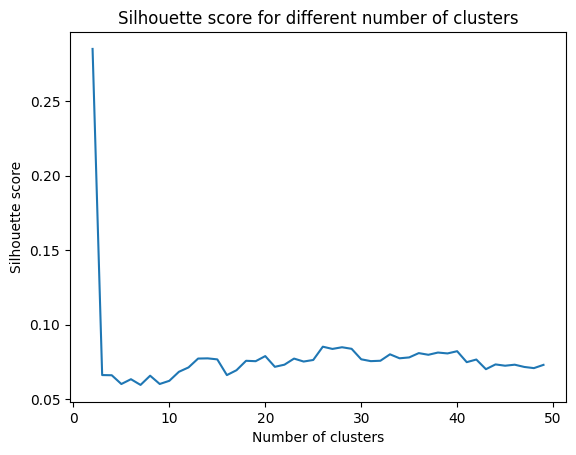

In [103]:
## KNN clustring
from sklearn.cluster import KMeans
from multiprocessing import Pool
import sklearn.metrics
from matplotlib import pyplot as plt
import tqdm

numpy_data = StandardScaler().fit_transform(numpy_data)



# silhouette score
cluster_range = range(2, 50)
kmeans = lambda n_clusters: KMeans(n_clusters=n_clusters, random_state=0).fit_predict(numpy_data)
def silhouette_score(n_clusters):
    kmeans_model = kmeans(n_clusters)
    return sklearn.metrics.silhouette_score(numpy_data, kmeans_model)
s_scores = [silhouette_score(cluster) for cluster in cluster_range]
plt.plot(cluster_range, s_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette score for different number of clusters');

# choose K ∗ with the maximum average silhouette
print("choice 1",max(s_scores), cluster_range[s_scores.index(max(s_scores))])

# Choose the smallest K such that all clusters have average $s(i)$ > overall average
mean_silhouette = np.mean(s_scores)
print("choice 2", cluster_range[next(i for i, score in enumerate(s_scores) if score > mean_silhouette)])



  0%|          | 0/48 [00:00<?, ?it/s]

100%|██████████| 48/48 [01:26<00:00,  1.79s/it]

choice 3 9


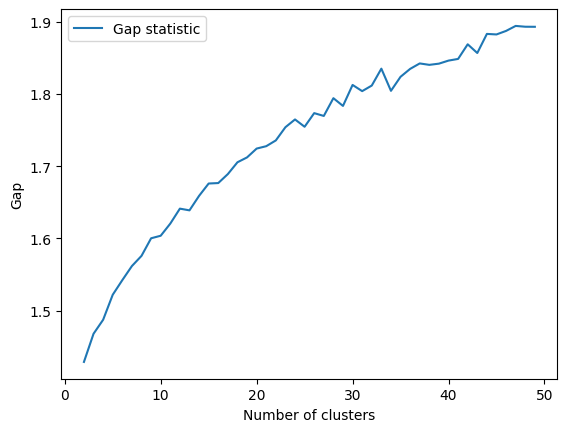

In [106]:
def gap_statistic(range_n_clusters):
    def wk(labels, data, k):
        clusters = {i: data[labels == i] for i in range(k)}
        centroids = np.array([np.mean(clusters[i], axis=0) for i in range(k)])
        w_k = 0
        for l in range(k):
            cluster = clusters[l]
            N_l = cluster.shape[0]
            if N_l == 0: continue
            dist = np.linalg.norm(cluster - centroids[l], axis=1)
            D_l = N_l * np.sum(dist**2)
            w_k += D_l / (2 * N_l)
        return w_k

    sim_data_sets = [np.random.uniform(np.min(numpy_data, axis=0), 
                                       np.max(numpy_data, axis=0), 
                                       size=numpy_data.shape) 
                     for _ in range(20)]  

    w_ks, u_ks = [], []
    for k in tqdm.tqdm(range_n_clusters):
        labels = KMeans(n_clusters=k, n_init=10, random_state=0).fit_predict(numpy_data)
        w_ks.append(wk(labels, numpy_data, k))

        sim_wks = []
        for sim in sim_data_sets:
            sim_labels = KMeans(n_clusters=k, n_init=10, random_state=0).fit_predict(sim)
            sim_wks.append(wk(sim_labels, sim, k))
        u_ks.append(sim_wks)  
    u_ks = np.array(u_ks)

    g_k = np.log(u_ks.mean(axis=1)) - np.log(w_ks)  # Compute gap statistic
    return g_k, u_ks

g, u = gap_statistic(cluster_range)

s = np.std(np.log(u), axis=1) * np.sqrt(1 + 1 / 20)

best_k = None
for i in range(len(g)-1):  # iterating over all values of g except the last one
    if g[i] >= g[i+1] - s[i+1]:
        best_k = cluster_range[i]
        break

if best_k is None:
    best_k = cluster_range[-1]  #

print("choice 3", best_k)
plt.plot(cluster_range, g, label='Gap statistic')
plt.xlabel('Number of clusters')
plt.ylabel('Gap')
plt.legend()
plt.show()


100%|██████████| 48/48 [00:32<00:00,  1.46it/s]


Optimal number of components (BIC): 2
Optimal number of components (AIC): 15
Silhouette score for GMM clustering: 0.272


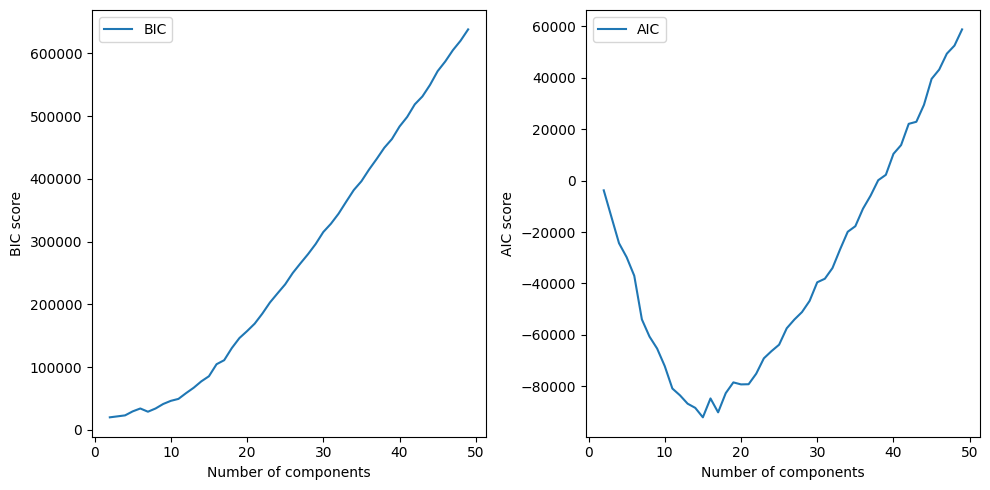

In [ ]:
 #guassian mixture model GPT
from sklearn.mixture import GaussianMixture
n_components_range = range(2, 50)
bic = []
aic = []

for n_components in tqdm.tqdm(n_components_range):
    # Fit GMM
    gmm = GaussianMixture(n_components=n_components, 
                         random_state=0,
                         n_init=10)
    gmm.fit(numpy_data)
    
    bic.append(gmm.bic(numpy_data))
    aic.append(gmm.aic(numpy_data))

# Plot the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(n_components_range, bic, label='BIC')
plt.xlabel('Number of components')
plt.ylabel('BIC score')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(n_components_range, aic, label='AIC')
plt.xlabel('Number of components')
plt.ylabel('AIC score')
plt.legend()
plt.tight_layout()

# Find optimal number of components
optimal_n_components_bic = n_components_range[np.argmin(bic)]
optimal_n_components_aic = n_components_range[np.argmin(aic)]

print(f"Optimal number of components (BIC): {optimal_n_components_bic}")
print(f"Optimal number of components (AIC): {optimal_n_components_aic}")

# Fit final model with optimal components
gmm_final = GaussianMixture(n_components=optimal_n_components_bic, 
                           random_state=0,
                           n_init=10)
labels = gmm_final.fit_predict(numpy_data)

# Calculate silhouette score for the GMM clustering
silhouette_gmm = sklearn.metrics.silhouette_score(numpy_data, labels)
print(f"Silhouette score for GMM clustering: {silhouette_gmm:.3f}")


# K-means — Week 1 & Week 9
# Gaussian Mixture Models (GMM) — Week 9
# Gap statistics — Week 9

# Hierarchical clustering — Week 9
# Self-Organizing Maps (SOM) — Week 10
# Spectral Clustering (SC) — Week 11
# Non-negative Matrix Factorization (NMF) — Week 11
# Archetypal Analysis (AA) — Week 11
# Independent Component Analysis (ICA) — Week 11